<a href="https://colab.research.google.com/github/Alf-caput/NFL2022_TacklePredictNN/blob/dev2/PracticaFinal_TacklingNFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import gdown
import os
id = '1V_fIjH-WGHTVgyRkdNFkZ6XxiqDoaMrA'
folder = 'nfl-big-data-bowl-2024'
endpoint = '.zip'

url = f'https://drive.google.com/uc?id={id}'

output = folder + endpoint

if not os.path.exists(output):
    gdown.download(url, output, quiet=False)

In [48]:
from zipfile import ZipFile

if not os.path.exists(folder):
	with ZipFile(output, 'r') as zObject:
		zObject.extractall(folder)

In [49]:
import pandas as pd
import os

csv_files = [file for file in os.listdir(folder) if file.endswith('.csv')]
csv_files.sort()

In [50]:
print(csv_files)

['games.csv', 'players.csv', 'plays.csv', 'tackles.csv', 'tracking_week_1.csv', 'tracking_week_2.csv', 'tracking_week_3.csv', 'tracking_week_4.csv', 'tracking_week_5.csv', 'tracking_week_6.csv', 'tracking_week_7.csv', 'tracking_week_8.csv', 'tracking_week_9.csv']


Dentro de la carpeta nfl-big-data-bowl-2024 se encuentran los csv que utilizaremos, a continuación creamos un diccionario para facilitarnos el acceso a los diferentes dataframes (dfs).

In [51]:
if 'dfs' not in locals():
    dfs = {os.path.splitext(file)[0]: pd.read_csv(os.path.join(folder, file)) for file in csv_files}

In [52]:
dfs.keys()

dict_keys(['games', 'players', 'plays', 'tackles', 'tracking_week_1', 'tracking_week_2', 'tracking_week_3', 'tracking_week_4', 'tracking_week_5', 'tracking_week_6', 'tracking_week_7', 'tracking_week_8', 'tracking_week_9'])

In [53]:
df_week1 = dfs['tracking_week_1']

game_ids = df_week1['gameId'].unique()
df_week1_game1 = df_week1[df_week1['gameId']==game_ids[0]]

play_ids = df_week1_game1['playId'].unique()
df_week1_game1_play1 = df_week1_game1[df_week1_game1['playId']==play_ids[0]]

frame_ids = df_week1_game1_play1['frameId'].unique()
df_week1_game1_play1_frame1 = df_week1_game1_play1[df_week1_game1_play1['frameId']==frame_ids[0]]

In [64]:
df_week1_game1_play1_frame1.head(1)

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.9,NaN


In [66]:
df_week1_game1_play1_frame1.drop(columns=['displayName', 'jerseyNumber'], inplace=True)
df_week1_game1_play1_frame1.head()

C:\Users\alfre\AppData\Local\Temp\ipykernel_17380\905074420.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_week1_game1_play1_frame1.drop(columns=['displayName', 'jerseyNumber'], inplace=True)


,gameId,playId,nflId,frameId,time,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,1,2022-09-08 20:24:05.200000,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
22,2022090800,56,38577.0,1,2022-09-08 20:24:05.200000,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN
44,2022090800,56,41239.0,1,2022-09-08 20:24:05.200000,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN
66,2022090800,56,42392.0,1,2022-09-08 20:24:05.200000,BUF,left,88.25,28.74,0.67,1.97,0.07,244.21,30.29,NaN
88,2022090800,56,42489.0,1,2022-09-08 20:24:05.200000,BUF,left,80.60,38.29,6.23,0.90,0.62,140.05,189.38,NaN


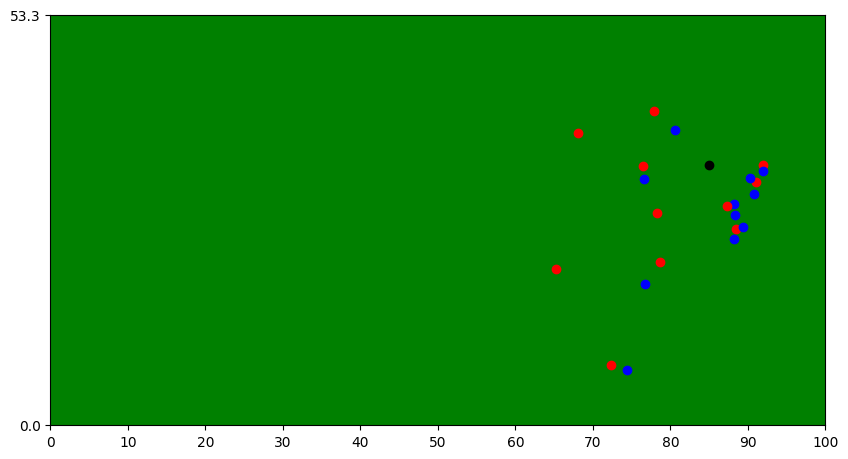

In [63]:
import matplotlib.pyplot as plt

frames = df_week1_game1_play1_frame1['frameId'].unique()
clubs = df_week1_game1_play1_frame1['club'].unique()

fig, ax = plt.subplots(figsize=(10, 5.33))

for i, row in df_week1_game1_play1_frame1.iterrows():
    if row['club'] == clubs[0]:
        color = 'blue'
    elif row['club'] == clubs[1]:
        color = 'red'
    else:
        color = 'black'
    ax.scatter(row['x'], row['y'], marker='o', color=color)
plt.xticks(range(0, 110, 10))
plt.yticks([0, 53.3])
ax.set_facecolor('green')

plt.show()
